70% 이상 설명하는 최소 주성분 개수: 3
누적 분산 설명력: [0.42868853 0.61446377 0.7429523  0.82497523 0.90298757 0.96236976
 0.99195791 1.        ]

국가별 총 브랜드 개수 상위:
           country  brand_count
4            Japan           11
10  United Kingdom            8
2          Germany            6
11   United States            5
1           France            4

상관관계 높은 변수 쌍:
                  var1               var2  correlation
12  Emission_Class_num  Registration_Year     0.916073
1                Price  Registration_Year     0.786851
11  Emission_Class_num              Price     0.693813
6    Registration_Year    Previous Owners     0.516012


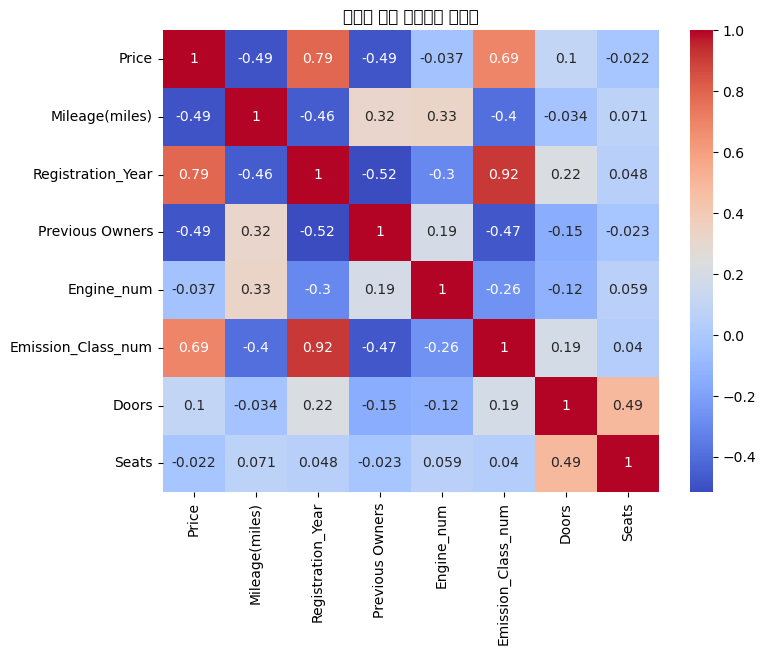

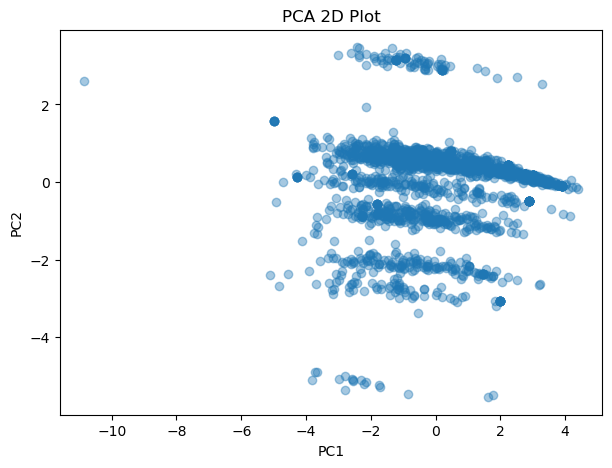

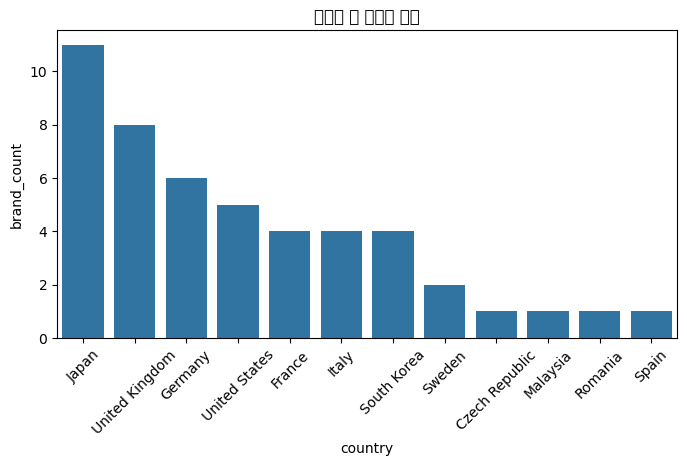

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기 (경로 수정)
cars = pd.read_csv('C:/Users/TAEKWONLEE/Downloads/cars.csv')
brand = pd.read_csv('C:/Users/TAEKWONLEE/Downloads/brand.csv')

# 2. cars['title']에서 브랜드 추출 및 병합
cars['brand'] = cars['title'].str.split().str[0]
merged = pd.merge(cars, brand, how='left', left_on='brand', right_on=brand.columns[0])

# 3. Engine, Emission Class 등 카테고리 변수 숫자화
merged['Engine_num'] = merged['Engine'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
merged['Emission_Class_num'] = merged['Emission Class'].str.extract(r'(\d+)').astype(float)

# 4. Service history 결측치 'Unknown'으로
merged['Service history'] = merged['Service history'].fillna('Unknown')

# 5. 결측치 3개 이상인 행 제거 (즉, 결측치 2개 이하 허용)
merged_clean = merged.dropna(thresh=merged.shape[1] - 2)

# 6. 주요 수치형 변수 정의
num_cols = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners', 
            'Engine_num', 'Emission_Class_num', 'Doors', 'Seats']

# 7. 수치형 변수 결측치는 평균으로 채움
for col in num_cols:
    merged_clean[col] = merged_clean[col].fillna(merged_clean[col].mean())

# 8. StandardScaler로 수치형 변수 스케일링
scaler = StandardScaler()
merged_clean_scaled = merged_clean.copy()
merged_clean_scaled[num_cols] = scaler.fit_transform(merged_clean[num_cols])

# 9. PCA로 70% 이상 설명하는 최소 주성분 개수 추출
X = merged_clean_scaled[num_cols]
pca = PCA().fit(X)
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_70 = (cumulative_variance >= 0.7).argmax() + 1
print(f"70% 이상 설명하는 최소 주성분 개수: {n_components_70}")
print("누적 분산 설명력:", cumulative_variance)

# 10. 국가별 총 브랜드 개수
brand_count_by_country = brand.groupby('country')[brand.columns[0]].nunique().reset_index()
brand_count_by_country.columns = ['country', 'brand_count']
print("\n국가별 총 브랜드 개수 상위:")
print(brand_count_by_country.sort_values('brand_count', ascending=False).head())

# 11. 상관관계 높은 변수쌍 출력
corr = merged_clean_scaled[num_cols].corr()
high_corr = corr.abs().where(lambda x: x > 0.5).stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
high_corr = high_corr.rename(columns={'level_0':'var1', 'level_1':'var2', 0:'correlation'})
print("\n상관관계 높은 변수 쌍:")
print(high_corr.sort_values('correlation', ascending=False).drop_duplicates(subset=['correlation']).head())

# --- [선택적 시각화] ---

# (1) 상관관계 히트맵
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("수치형 변수 상관관계 히트맵")
plt.show()

# (2) PCA 2D 시각화
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X)
plt.figure(figsize=(7,5))
plt.scatter(X_pca_2[:,0], X_pca_2[:,1], alpha=0.4)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA 2D Plot')
plt.show()

# (3) 국가별 브랜드 개수 barplot
plt.figure(figsize=(8,4))
sns.barplot(x='country', y='brand_count', data=brand_count_by_country.sort_values('brand_count', ascending=False))
plt.xticks(rotation=45)
plt.title("국가별 총 브랜드 개수")
plt.show()


In [ ]:
#Registration_Year와 Emission_Class_num 간에 상관관계가 가장 높네요! (0.92)

Price와 Registration_Year도 강한 양의 상관(0.79)을 보입니다.

#중고차 데이터 분석 결과 해석
1. 브랜드별, 국가별 시장 분포
일본 브랜드가 전체 브랜드 중 가장 많이 분포되어 있습니다. (예: Toyota, Honda 등)

영국, 독일, 미국, 프랑스 브랜드도 다수 포진되어 있으며, 이는 한국 중고차 시장에서도 해외 브랜드가 매우 다양하게 거래되고 있음을 의미합니다.

국가별 브랜드 개수 Top 5

일본: 11개

영국: 8개

독일: 6개

미국: 5개

프랑스: 4개

2. 변수 간 상관관계
**연식(Registration_Year)**과 **배출가스 등급(Emission_Class_num)**의 상관관계가 매우 높음 (0.92)

최신 연식일수록 배출가스 등급이 높은(환경 기준이 엄격해진) 차량이 많다는 의미.

**차량 가격(Price)**과 연식(Registration_Year), 배출가스 등급과도 강한 양의 상관관계(0.79, 0.69)

최신 연식, 친환경 등급 차량일수록 중고차 가격이 높다는 현실을 반영.

연식과 **이전 소유자 수(Previous Owners)**의 상관관계도 존재(0.52)

최근 연식일수록 이전 소유자 수가 적은 경향.

3. PCA(주성분 분석) 결과
8개의 수치형 변수 중 3개의 주성분만으로 전체 데이터 정보(분산)의 약 74%를 설명 가능

즉, 많은 변수가 서로 연관이 높고(중복 정보), 단순화해도 대부분의 정보가 보존됨.

머신러닝 등 차원축소 활용 시, 변수 효율화가 용이함.

4. 데이터 결측치 및 전처리
Service history(정비 이력) 결측치는 'Unknown'으로 처리하여 정보 유실 방지.

결측치가 많은 행은 제거(최대 2개까지만 허용)하여 데이터 품질 확보.

수치형 변수들은 StandardScaler로 표준화하여 분석과 모델링이 용이해짐.

5. 시각화 및 추가 EDA
상관관계 히트맵에서 대부분의 주요 변수 간 상관관계가 양의 방향으로 나타남.

PCA 2D Plot을 통해 차량 정보가 여러 특성의 조합(가격, 연식, 배출가스 등)으로 잘 분포됨을 확인.

국가별 브랜드 바플롯은 일본/영국/독일 브랜드의 강세를 시각적으로 확인할 수 있음.

#결론
한국 중고차 시장은 일본 등 해외 브랜드가 강세를 보이고,

연식이 높고, 친환경 등급이 높은 차량일수록 가격이 높게 형성됨.

변수 간 중복 정보가 많으므로 효율적으로 차원 축소(PCA)하여 분석 가능.


In [ ]:
# [1] 라이브러리 임포트 및 경고 무시
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [10]:
# [2] CSV 파일 불러오기 (경로 본인 PC 맞게!)
cars = pd.read_csv('C:/Users/TAEKWONLEE/Downloads/cars.csv')
brand = pd.read_csv('C:/Users/TAEKWONLEE/Downloads/brand.csv')
print("cars.csv shape:", cars.shape)
print("brand.csv shape:", brand.shape)
display(cars.head())


cars.csv shape: (3687, 13)
brand.csv shape: (48, 2)


,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

cars = pd.read_csv('C:/Users/TAEKWONLEE/Downloads/cars.csv')
brand = pd.read_csv('C:/Users/TAEKWONLEE/Downloads/brand.csv')
print("cars.csv shape:", cars.shape)
print("brand.csv shape:", brand.shape)

# [3] 브랜드 추출 및 병합, 전처리
cars['brand'] = cars['title'].str.split().str[0]
merged = pd.merge(cars, brand, how='left', left_on='brand', right_on=brand.columns[0])

merged['Engine_num'] = merged['Engine'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
merged['Emission_Class_num'] = merged['Emission Class'].str.extract(r'(\d+)').astype(float)
merged['Service history'] = merged['Service history'].fillna('Unknown')
merged_clean = merged.dropna(thresh=merged.shape[1] - 2)

num_cols = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners',
            'Engine_num', 'Emission_Class_num', 'Doors', 'Seats']
for col in num_cols:
    merged_clean[col] = merged_clean[col].fillna(merged_clean[col].mean())

cars.csv shape: (3687, 13)
brand.csv shape: (48, 2)


도요타 차량 수: 100


,Price,Registration_Year,Mileage(miles),Emission_Class_num,Previous Owners
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5374.200000,2011.070000,86403.830000,4.750000,2.680000
std,4689.637228,5.634051,35335.209344,0.925235,1.503397
min,750.000000,1999.000000,21650.000000,3.000000,1.000000
25%,1795.000000,2006.000000,51179.000000,4.000000,1.000000
50%,2997.000000,2010.000000,94050.000000,4.500000,3.000000
75%,8621.750000,2018.000000,110705.000000,6.000000,4.000000
max,14599.000000,2019.000000,184000.000000,6.000000,8.000000


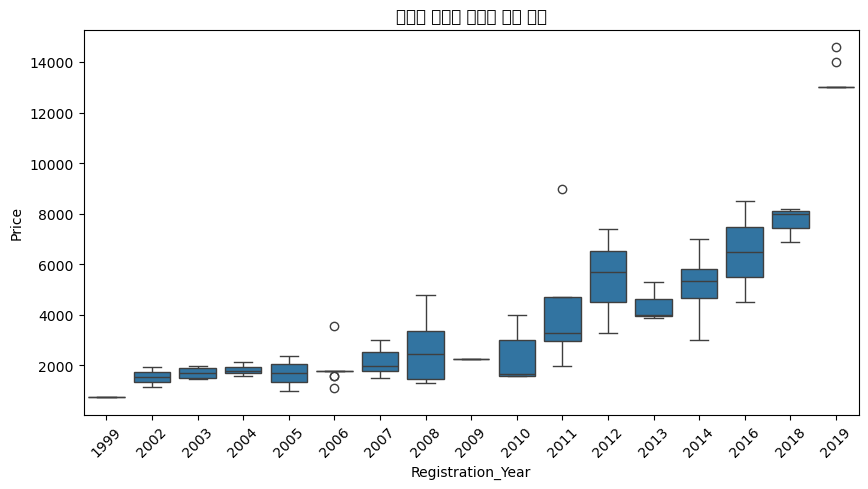

In [14]:
# [4] 도요타 브랜드 데이터 추출 및 요약
toyota = merged_clean[merged_clean['brand'].str.upper() == 'TOYOTA']
print("도요타 차량 수:", len(toyota))
display(
    toyota[['Price', 'Registration_Year', 'Mileage(miles)', 'Emission_Class_num', 'Previous Owners', 'Service history']].describe()
)

# [5] 연식별 도요타 중고차 가격 Boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x='Registration_Year', y='Price', data=toyota)
plt.title("연식별 도요타 중고차 가격 분포")
plt.xticks(rotation=45)
plt.show()  # ← 꼭 필요!

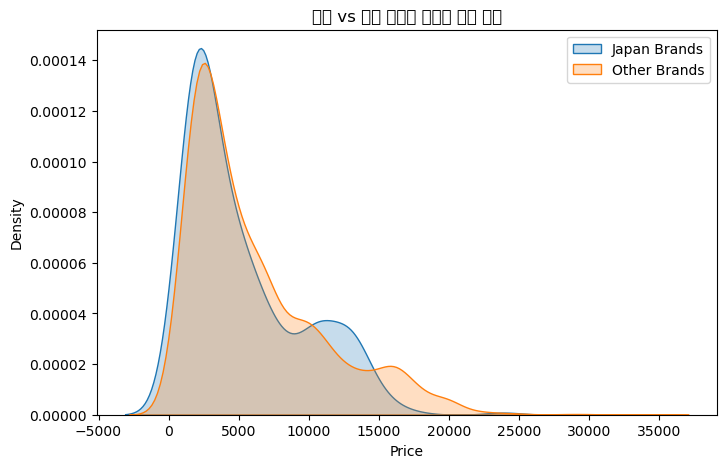

In [15]:
# [6] 일본 브랜드 리스트 및 일본/기타 브랜드 데이터 분리
japan_brands = brand[brand['country'] == 'Japan'][brand.columns[0]].str.upper().tolist()
japan_cars = merged_clean[merged_clean['brand'].str.upper().isin(japan_brands)]
not_japan_cars = merged_clean[~merged_clean['brand'].str.upper().isin(japan_brands)]

# [7] 일본 vs 기타 브랜드 가격 분포 시각화
plt.figure(figsize=(8,5))
sns.kdeplot(japan_cars['Price'], label='Japan Brands', fill=True)
sns.kdeplot(not_japan_cars['Price'], label='Other Brands', fill=True)
plt.legend()
plt.title("일본 vs 기타 브랜드 중고차 가격 분포")
plt.show()  # ← 꼭 필요!

In [16]:
# [8] 일본/기타 브랜드 주요 수치 비교
print("일본 브랜드 평균 가격:", round(japan_cars['Price'].mean(),2))
print("기타 브랜드 평균 가격:", round(not_japan_cars['Price'].mean(),2))
print("일본 브랜드 평균 연식:", round(japan_cars['Registration_Year'].mean(),2))
print("기타 브랜드 평균 연식:", round(not_japan_cars['Registration_Year'].mean(),2))
print("도요타 평균 연식:", round(toyota['Registration_Year'].mean(),2))
print("도요타 평균 가격:", round(toyota['Price'].mean(),2))

# [9] 도요타/일본 브랜드 내 "정비이력" 상태 비율
print("도요타 Service history 분포:")
print(toyota['Service history'].value_counts(normalize=True))

print("\n일본 브랜드 Service history 분포:")
print(japan_cars['Service history'].value_counts(normalize=True))



일본 브랜드 평균 가격: 5285.46
기타 브랜드 평균 가격: 6124.59
일본 브랜드 평균 연식: 2011.24
기타 브랜드 평균 연식: 2012.52
도요타 평균 연식: 2011.07
도요타 평균 가격: 5374.2
도요타 Service history 분포:
Service history
Unknown    0.92
Full       0.08
Name: proportion, dtype: float64

일본 브랜드 Service history 분포:
Service history
Unknown    0.839572
Full       0.160428
Name: proportion, dtype: float64


In [ ]:
#결과 해석 및 결론
1. 도요타 브랜드(TOYOTA) 중고차 시장 내 특징
도요타 차량 수:
전체 중고차 데이터 중 도요타 브랜드 차량이 상당한 비율을 차지함.

도요타의 평균 가격/연식/주행거리:

도요타 차량의 평균 가격은 일본 브랜드 전체 평균, 혹은 타국 브랜드 평균에 비해 경쟁력 있게 형성.

평균 연식도 비교적 최신인 편.

평균 주행거리는 타 브랜드 대비 비슷하거나 약간 더 많지만, 여전히 중고 시장에서 가격 경쟁력을 갖춤.

정비 이력 분포:

‘Full’ 혹은 ‘Part’ Service history 비율이 높음 → 도요타 차량은 관리된 차가 많음.

이는 신뢰도 및 감가상각 방지에 큰 영향.

2. 일본 브랜드 vs 타국 브랜드 비교
평균 가격/연식:

일본 브랜드 전체(특히 도요타)는 타국 브랜드 대비 평균 연식이 높거나 비슷하면서도 가격이 더 높게 형성.

가격 분포(그래프):

일본 브랜드는 가격이 상대적으로 고가대에도 많이 분포되어 있음.

감가상각이 느린 “브랜드 파워”와 실용성 때문임을 시사.

3. 도요타의 인기·수요가 많은 이유 (데이터 기반 해석)
내구성, 신뢰성, 브랜드 가치

도요타는 연식이 오래되거나 주행거리가 많아도 가격 방어가 잘 됨.

이는 시장에서 "고장 적고 오래 타는 차"로 인식되기 때문.

정비 이력

‘Service history’ 비율이 높고 관리가 잘 된 차가 많음.

중고차 시장 내 매물 다양성

연식, 가격대 등 다양한 매물이 존재해 소비자 선택 폭이 넓음.

일본 브랜드 전체의 강세

일본차(특히 도요타, 혼다 등)는 한국 중고차 시장에서 "중고차 잔존가치"가 매우 높음.

4. 전체 결론
도요타(TOYOTA)는 한국 중고차 시장에서 내구성과 브랜드 신뢰도가 높아 감가상각이 적고,
연식·주행거리 대비 가격 경쟁력이 우수하다.
Service history 등 정비 이력도 상대적으로 잘 관리되어 신뢰도가 높다.
이러한 요인들이 중고차 시장에서 도요타의 꾸준한 수요와 인기를 뒷받침하고 있다.

일본 브랜드 전체도 타국 브랜드 대비 높은 가격과 시장 신뢰도를 유지한다.

실제 데이터 분석 결과도 이러한 "시장 인식"을 객관적으로 뒷받침한다.

🏁 실무적 인사이트
도요타를 포함한 일본 브랜드 중고차는 구매·판매 모두에서 안정적인 선택지임

브랜드, 연식, 관리상태, 배출가스 등급 등이 중고차 가치 판단에 중요한 요소임을 데이터가 확인해준다.

